In [22]:
!pip install madgrad

In [74]:
import os
import random
from pathlib import Path
import sys

import numpy as np
import pandas as pd
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from scipy.special import softmax
from transformers import (
    AutoTokenizer, Trainer, TrainingArguments, get_linear_schedule_with_warmup
)
import torch
from torchvision.models import ResNet152_Weights
import japanese_clip as ja_clip
from madgrad import MADGRAD


sys.path.append('../')
from src.data.prepare import load_base_df
from src.models.MMBT.dataset import collate_fn
from src.models.MMBT.mmbt import PRETRAINED_MODEL_CKP
from src.models.MMBT_with_CLIP_encoder.dataset import MMBTClipDsataset
from src.models.MMBT_with_CLIP_encoder.img_encoder import ClipEncoderMulti
from src.models.MMBT_with_CLIP_encoder.mmbt_with_clip import load_model
from src.models.utils import fix_seed, plot_confusion_matrix

In [2]:
SEED_SHUFFLE = 42
SEED_TRAIN = 0

## データ読み込み

In [3]:
train_df, test_df, submission_df = load_base_df('../dataset/csv/', '../dataset/imgs/')

In [4]:
print(f'train_df.shape: {train_df.shape}')
display(train_df.head())

print(f'test_df.shape: {test_df.shape}')
display(test_df.head())

train_df.shape: (24962, 5)


,id,odai_photo_file_name,text,is_laugh,img_path
0,ge5kssftl,9fkys1gb2r.jpg,君しょっちゅうソレ自慢するけど、ツムジ２個ってそんなに嬉しいのかい？,0,../dataset/imgs/train/9fkys1gb2r.jpg
1,r7sm6tvkj,c6ag0m1lak.jpg,これでバレない？授業中寝てもバレない？,0,../dataset/imgs/train/c6ag0m1lak.jpg
2,yp5aze0bh,whtn6gb9ww.jpg,「あなたも感じる？」\n『ああ…、感じてる…』\n「後ろに幽霊いるよね…」\n『女のな…』,0,../dataset/imgs/train/whtn6gb9ww.jpg
3,ujaixzo56,6yk5cwmrsy.jpg,大塚愛聞いてたらお腹減った…さく、らんぼと牛タン食べたい…,0,../dataset/imgs/train/6yk5cwmrsy.jpg
4,7vkeveptl,0i9gsa2jsm.jpg,熊だと思ったら嫁だった,0,../dataset/imgs/train/0i9gsa2jsm.jpg


test_df.shape: (6000, 5)


,id,odai_photo_file_name,text,img_path,is_laugh
0,rfdjcfsqq,nc1kez326b.jpg,僕のママ、キャラ弁のゆでたまごに８時間かかったんだ,../dataset/imgs/test/nc1kez326b.jpg,0
1,tsgqmfpef,49xt2fmjw0.jpg,かわいいが作れた！,../dataset/imgs/test/49xt2fmjw0.jpg,0
2,owjcthkz2,9dtscjmyfh.jpg,来世の志茂田景樹,../dataset/imgs/test/9dtscjmyfh.jpg,0
3,rvgaocjyy,osa3n56tiv.jpg,ちょ、あの、オカン、これ水風呂やねんけど、なんの冗談??,../dataset/imgs/test/osa3n56tiv.jpg,0
4,uxtwu5i69,yb1yqs4pvb.jpg,「今日は皆さんにザリガニと消防車の違いを知ってもらいたいと思います」『どっちも同じだろ。両方...,../dataset/imgs/test/yb1yqs4pvb.jpg,0


## データ準備, 学習

In [5]:
train_idx, valid_idx = train_test_split(list(range(len(train_df))), test_size=.2, random_state=SEED_SHUFFLE, stratify=train_df['is_laugh'])

In [11]:
# データセット準備
MAX_SEQENCE_LEN = 48
tokenizer = AutoTokenizer.from_pretrained("cl-tohoku/bert-base-japanese-whole-word-masking")
encoder, preprocess = ja_clip.load('rinna/japanese-clip-vit-b-16', cache_dir='/tmp/japanese_clip')
train_ds = MMBTClipDsataset(train_df.iloc[train_idx], tokenizer, image_transform=preprocess, max_seq_len=MAX_SEQENCE_LEN)
valid_ds = MMBTClipDsataset(train_df.iloc[valid_idx], tokenizer, image_transform=preprocess, max_seq_len=MAX_SEQENCE_LEN)
test_ds = MMBTClipDsataset(test_df, tokenizer, image_transform=preprocess, max_seq_len=MAX_SEQENCE_LEN)

In [13]:
def get_optimizer_and_scheduler(model, t_total):
    no_decay = [
        'bias',
        'LayerNorm.weight'
    ]
    weight_decay = 0.0005
    optimizer_grouped_params = [
        {
            'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            'weight_decay': weight_decay
        },
        {
            'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            'weight_decay': 0
        }
    ]
    warmup_steps = t_total // 10
    optimizer = MADGRAD(optimizer_grouped_params, lr=2e-4)
    scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, t_total)
    return optimizer, scheduler

In [12]:
len(train_ds)

19969

In [15]:
GRADIENT_ACCUMULATION_STEPS = 20
EPOCHS = 10
BATCH_SIZE = 8
t_total = (len(train_ds) // (GRADIENT_ACCUMULATION_STEPS * BATCH_SIZE)) * EPOCHS
t_total

1240

In [16]:
# seed値の固定
fix_seed(SEED_TRAIN)
model = load_model(encoder)
MODEL_DST = Path('../model/mmbt_with_clip_exp01')
EPOCHS = 5
BATCH_SIZE = 8
# BATCH_SIZEを1単位として、指定数分だけ勾配を貯めておき、その平均で勾配を更新する。
# 以下、参考
# - https://huggingface.co/docs/transformers/v4.22.1/en/main_classes/trainer#transformers.TrainingArguments
# - https://qiita.com/cfiken/items/1de519e741cbbc09818c
# - https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/02/19/gradient-accumulation.html
GRADIENT_ACCUMULATION_STEPS = 20
SAVE_STEPS = 25
trainer_args = TrainingArguments(
    output_dir=str(MODEL_DST),
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    num_train_epochs=EPOCHS,
    evaluation_strategy="steps",
    eval_steps=SAVE_STEPS,
    save_strategy="steps",
    save_steps=SAVE_STEPS,
    logging_steps=SAVE_STEPS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=12,
    save_total_limit=1,
    fp16=True,
    remove_unused_columns=False,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    load_best_model_at_end=True,
    logging_dir='./logs',
    report_to="none"
)
t_total = (len(train_ds) // (GRADIENT_ACCUMULATION_STEPS * BATCH_SIZE)) * EPOCHS
optimizer, scheduler = get_optimizer_and_scheduler(model, t_total)
trainer = Trainer(
    model=model,
    args=trainer_args,
    tokenizer=tokenizer,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    data_collator=collate_fn,
    optimizers=(optimizer, scheduler)
)

trainer.train()

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Using cuda_amp half precision backend
***** Running training *****
  Num examples = 19969
  Num Epochs = 5
  Instantaneous ba

Step,Training Loss,Validation Loss
25,0.694700,0.713962
50,0.682200,0.662206
75,0.678200,0.665857
100,0.670400,0.661054
125,0.693800,0.652659
150,0.654800,0.667227
175,0.645500,0.670561
200,0.655300,0.644605
225,0.649000,0.663873
250,0.668000,0.673815


***** Running Evaluation *****
  Num examples = 4993
  Batch size = 12
Saving model checkpoint to ../model/mmbt_with_clip_exp01/checkpoint-25
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in ../model/mmbt_with_clip_exp01/checkpoint-25/tokenizer_config.json
Special tokens file saved in ../model/mmbt_with_clip_exp01/checkpoint-25/special_tokens_map.json
Deleting older checkpoint [../model/mmbt_with_clip_exp01/checkpoint-225] due to args.save_total_limit
Deleting older checkpoint [../model/mmbt_with_clip_exp01/checkpoint-525] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4993
  Batch size = 12
Saving model checkpoint to ../model/mmbt_with_clip_exp01/checkpoint-50
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in ../model/mmbt_with_clip_exp01/checkpoint-50/tokenizer_config.json
Special tokens file saved in ../model/mmbt_with_clip_exp01/checkpoint-50/special_

TrainOutput(global_step=620, training_loss=0.5551443884449621, metrics={'train_runtime': 4919.7944, 'train_samples_per_second': 20.295, 'train_steps_per_second': 0.126, 'total_flos': 0.0, 'train_loss': 0.5551443884449621, 'epoch': 4.99})

In [68]:
def loss_df_from_history(history):
    result = {'loss': [], 'eval_loss': []}
    old_step = 0
    for h in history:
        for key in result:
            if key in h:
                loss = h[key]
                result[key].append(loss)
    result['step'] = sorted(set([h['step'] for h in history if 'train_loss' not in h]))
    return pd.DataFrame(result)

<AxesSubplot:xlabel='step'>

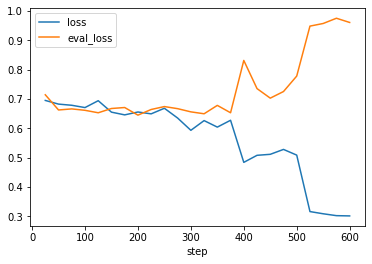

In [72]:
loss_df = loss_df_from_history(trainer.state.log_history)
loss_df.plot(x='step')

## 評価

In [17]:
# validationデータの予測値取得
val_preds = trainer.predict(valid_ds).predictions
# logg lossとaccuracy測定
loss = log_loss(valid_ds.df["is_laugh"].values, softmax(val_preds, axis=-1))
acc = accuracy_score(valid_ds.df['is_laugh'].values, np.argmax(val_preds, axis=-1))
print(f'log loss: {loss}')
print(f'accuracy: {acc}')

***** Running Prediction *****
  Num examples = 4993
  Batch size = 12


log loss: 0.6445279494808357
accuracy: 0.6326857600640897


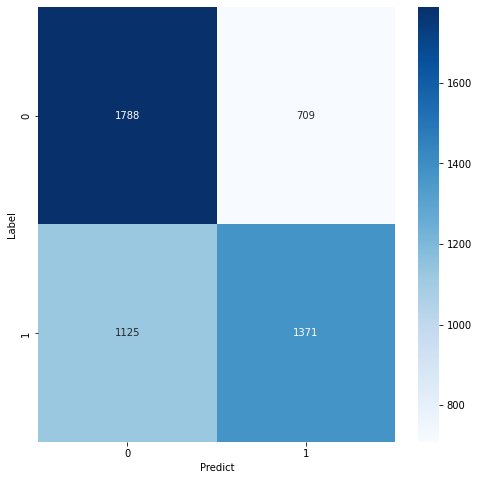

In [18]:
# 混同行列描画
plot_confusion_matrix(y_true=valid_ds.df['is_laugh'].values, y_pred=val_preds)

## テストデータの予測

In [21]:
y_pred = trainer.predict(test_ds).predictions

***** Running Prediction *****
  Num examples = 6000
  Batch size = 12


In [22]:
submission_df['is_laugh'] = softmax(y_pred, axis=1)[:, 1]
submission_df['is_laugh'] = submission_df['is_laugh'].astype(float)

In [23]:
output = '../results/submission_mmbt_with_clip.csv'
submission_df.to_csv(output, index=False)